<a href="https://colab.research.google.com/github/Jayveersinh-Raj/mask_rcnn_vs_yolov8/blob/main/mask_rcnn_vs_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jayveersinh Raj
# j.raj@innopolis.university
# BS20-DS-01

In [1]:
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 766.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=750f392204f50a727587f7e7d3cd38d0b4dd4ab205f51ae196ea36af42b4d9f8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
   

# Some dependencies

In [1]:
# Downloading detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

import os
import json
import cv2
import random
import numpy as np
import torch
import logging
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer, default_argument_parser, default_setup, default_writers, launch
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow
setup_logger()

<Logger detectron2 (DEBUG)>

# Dataset from roboflow

In [2]:
!curl -L "https://app.roboflow.com/ds/n7p0jneY6J?key=K3py9Eit3i" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   884  100   884    0     0   2094      0 --:--:-- --:--:-- --:--:--  2099
100 28.0M  100 28.0M    0     0  9547k      0  0:00:03  0:00:03 --:--:-- 14.3M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/photo_10_2023-04-28_20-23-02_jpg.rf.1d95c971de46782f571840eb4a162814.jpg  
 extracting: test/photo_10_2023-04-28_20-29-33_jpg.rf.81755c81c403fd24c4dcadf310db9055.jpg  
 extracting: test/photo_1_2023-04-28_20-22-52_jpg.rf.b67ecde7e4462e2f79e673f20a39f0bc.jpg  
 extracting: test/photo_2_2023-04-28_20-29-19_jpg.rf.5f417aa89e55c9886ee79799f9182102.jpg  
 extracting: test/photo_3_2023-04-28_20-22-42_jpg.rf.88407460a4b025a6344edcc2b89b1313.jpg  
 extracting: test/photo_3_2023-04-28_20-29-09_jpg.rf.410a659d

# Getting coco from workspace

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="") # Personal API key
project = rf.workspace("assignment-2-eehvr").project("applied-machine-learning-assignment-2-segmentation")
dataset = project.version(6).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Applied-Machine-Learning-Assignment-2-segmentation-6 in coco:: 100%|██████████| 248/248 [00:00<00:00, 1267.36it/s]


# Some exploratory ananlysis

In [4]:
# Just to check 
import json

# Load the COCO dataset file
with open('/content/valid/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)
count = 0
# Iterate over each annotation in the dataset
for annotation in coco_data['annotations']:
    # Get the segmentation data for the annotation
     segmentation = annotation['segmentation']
     #if len(segmentation) > 0:
     count+=1
     print(segmentation)
print(count)

[[209.002, 226, 159.188, 239.5, 118.037, 254, 97.462, 258, 61.726, 273, 47.648, 282.5, 44.399, 290, 43.316, 302, 48.731, 313, 63.892, 326, 80.135, 334, 100.711, 338.5, 108.291, 343, 181.929, 368, 226.328, 377, 252.318, 376.5, 283.723, 372, 305.381, 367.5, 328.122, 359.5, 374.687, 336.5, 386.599, 334, 407.174, 324.5, 408.257, 320.5, 397.428, 318, 398.511, 316, 410.423, 315.5, 441.827, 308.5, 459.154, 296, 465.651, 285.5, 464.569, 273.5, 455.905, 261, 429.915, 247, 386.599, 236, 369.272, 229.5, 342.2, 226.5, 302.132, 218.5, 264.23, 218, 209.002, 226]]
[[275.059, 178.5, 250.152, 186.5, 176.514, 237.5, 158.105, 253, 151.607, 263.5, 150.525, 275.5, 155.939, 287.5, 166.768, 297.5, 198.173, 314, 231.743, 325, 264.23, 330, 312.961, 341, 368.19, 349, 410.423, 351, 429.915, 349, 472.149, 339.5, 492.724, 330, 505.719, 317.5, 532.792, 254.5, 534.958, 237, 531.709, 228.5, 514.382, 212.5, 494.89, 204, 463.486, 195.5, 373.604, 177.5, 345.448, 174.5, 310.795, 174, 275.059, 178.5]]
[[359.526, 257.5, 32

# Registering coco

In [5]:
register_coco_instances("r_train", {}, f"/content/train/_annotations.coco.json", f"/content/train/")
register_coco_instances("r_valid", {}, f"/content/valid/_annotations.coco.json", f"/content/valid/")
register_coco_instances("r_test", {}, f"/content/test/_annotations.coco.json", f"/content/test/")

# Visualising image

WARNING [04/30 12:16:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/30 12:16:02 d2.data.datasets.coco]: Loaded 210 images in COCO format from /content/train/_annotations.coco.json


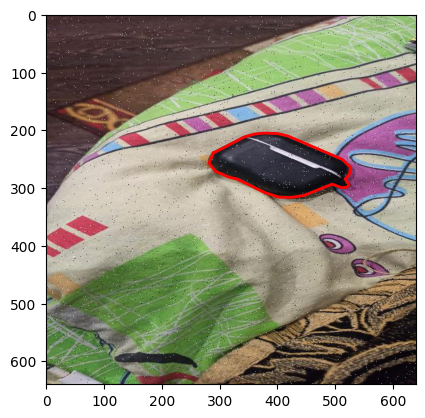

In [6]:
from matplotlib import pyplot as plt
from PIL import Image
dataset_train = DatasetCatalog.get("r_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

# Detectron 2 configurations

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("r_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("r_test",)#Test dataset registered in a previous cell
cfg.DATASETS.VALID = ("r_valid",)#Validation dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 27 # 26 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Evaluation and training

In [8]:
# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/30 12:17:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 181MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/30 12:17:17 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


[04/30 12:17:26 d2.utils.events]:  eta: 0:55:16  iter: 19  total_loss: 4.221  loss_cls: 3.39  loss_box_reg: 0.09361  loss_mask: 0.6988  loss_rpn_cls: 0.01349  loss_rpn_loc: 0.007285    time: 0.3368  last_time: 0.2836  data_time: 0.0190  last_data_time: 0.0048   lr: 4.9953e-06  max_mem: 1772M
[04/30 12:17:35 d2.utils.events]:  eta: 0:55:53  iter: 39  total_loss: 4.016  loss_cls: 3.195  loss_box_reg: 0.09163  loss_mask: 0.6895  loss_rpn_cls: 0.02024  loss_rpn_loc: 0.00604    time: 0.3417  last_time: 0.4530  data_time: 0.0140  last_data_time: 0.0050   lr: 9.9902e-06  max_mem: 1772M
[04/30 12:17:42 d2.utils.events]:  eta: 0:55:28  iter: 59  total_loss: 3.493  loss_cls: 2.719  loss_box_reg: 0.101  loss_mask: 0.6705  loss_rpn_cls: 0.01097  loss_rpn_loc: 0.008232    time: 0.3419  last_time: 0.3257  data_time: 0.0111  last_data_time: 0.0049   lr: 1.4985e-05  max_mem: 1772M
[04/30 12:17:50 d2.utils.events]:  eta: 0:55:49  iter: 79  total_loss: 2.642  loss_cls: 1.864  loss_box_reg: 0.1098  loss_

In [9]:
# Create the evaluator
evaluator = COCOEvaluator("r_test", cfg, False, output_dir="./output/")
# Set the evaluator to use the most recent checkpoint
trainer.resume_or_load(resume=False)
# Test the model on the test set
trainer.test(cfg, trainer.model, evaluators=[evaluator])

WARNING [04/30 13:20:38 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/30 13:20:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [04/30 13:20:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/30 13:20:39 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/test/_annotations.coco.json
[04/30 13:20:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/30 13:20:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/30 13:20:39 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[04/30 13:20:39 d2.data.common]: Serialized dataset takes 0.01 MiB
[04/30 13:20:39 d2.evaluation.evaluator]: Start inference on 10 batches
[04/30 13:20:42 d2.evaluation.evaluator]: Total inference time: 0:00:01.094645 (0.218929 s / iter per device, on 1 devices)
[04/30 13:20:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00

OrderedDict([('bbox',
              {'AP': 41.537509520182795,
               'AP50': 79.77151561309978,
               'AP75': 40.03236862147753,
               'APs': nan,
               'APm': nan,
               'APl': 41.537509520182795,
               'AP-Book-Airpods': nan,
               'AP-airpods': 51.36138613861386,
               'AP-book': 31.71363290175172}),
             ('segm',
              {'AP': 63.08921278904036,
               'AP50': 79.77151561309978,
               'AP75': 79.77151561309978,
               'APs': nan,
               'APm': nan,
               'APl': 63.453552708211994,
               'AP-Book-Airpods': nan,
               'AP-airpods': 84.30785775206733,
               'AP-book': 41.87056782601337})])

# Visualising ouptput

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0004999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("r_valid")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im

[04/30 13:48:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0004999.pth ...
WARNING [04/30 13:48:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/30 13:48:55 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/valid/_annotations.coco.json


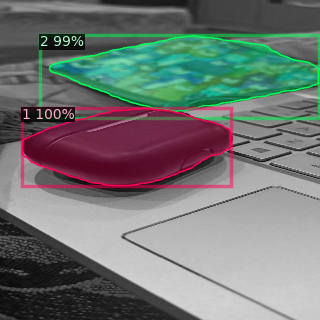

In [17]:
im

# Part 2: Yolov8

In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ultralytics==8.0.28

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.6/272.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.3 MB/s eta 0:00:00


In [1]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.28 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.4/78.2 GB disk)


In [2]:
from ultralytics import YOLO
from IPython.display import display, Image
!mkdir datasets
%cd /content/datasets

/content/datasets


# Downloading the dataset

In [3]:
!curl -L "https://app.roboflow.com/ds/1AZjC4ME11?key=vvO0UB59MX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   2668      0 --:--:-- --:--:-- --:--:--  2668
100 28.1M  100 28.1M    0     0  9660k      0  0:00:02  0:00:02 --:--:-- 11.4M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/photo_10_2023-04-28_20-23-02_jpg.rf.1d95c971de46782f571840eb4a162814.jpg  
 extracting: test/images/photo_10_2023-04-28_20-29-33_jpg.rf.81755c81c403fd24c4dcadf310db9055.jpg  
 extracting: test/images/photo_1_2023-04-28_20-22-52_jpg.rf.b67ecde7e4462e2f79e673f20a39f0bc.jpg  
 extracting: test/images/photo_2_2023-04-28_20-29-19_jpg.rf.5f417aa89e55c9886ee79799f9182102.jpg  
 extracting: test/images/photo_3_2023-04-28_20-22-42_jpg.rf.88407460a4b025a6344edcc2b89b1313.jpg  
 extr

# Training

In [4]:
%cd ..

/content


In [5]:
!yolo task=segment mode=train model=yolov8s-seg.pt data=/content/datasets/data.yaml epochs=20 plots=True

100% 22.8M/22.8M [00:01<00:00, 16.3MB/s]
Ultralytics YOLOv8.0.28 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/datasets/data.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dy

# The results plot

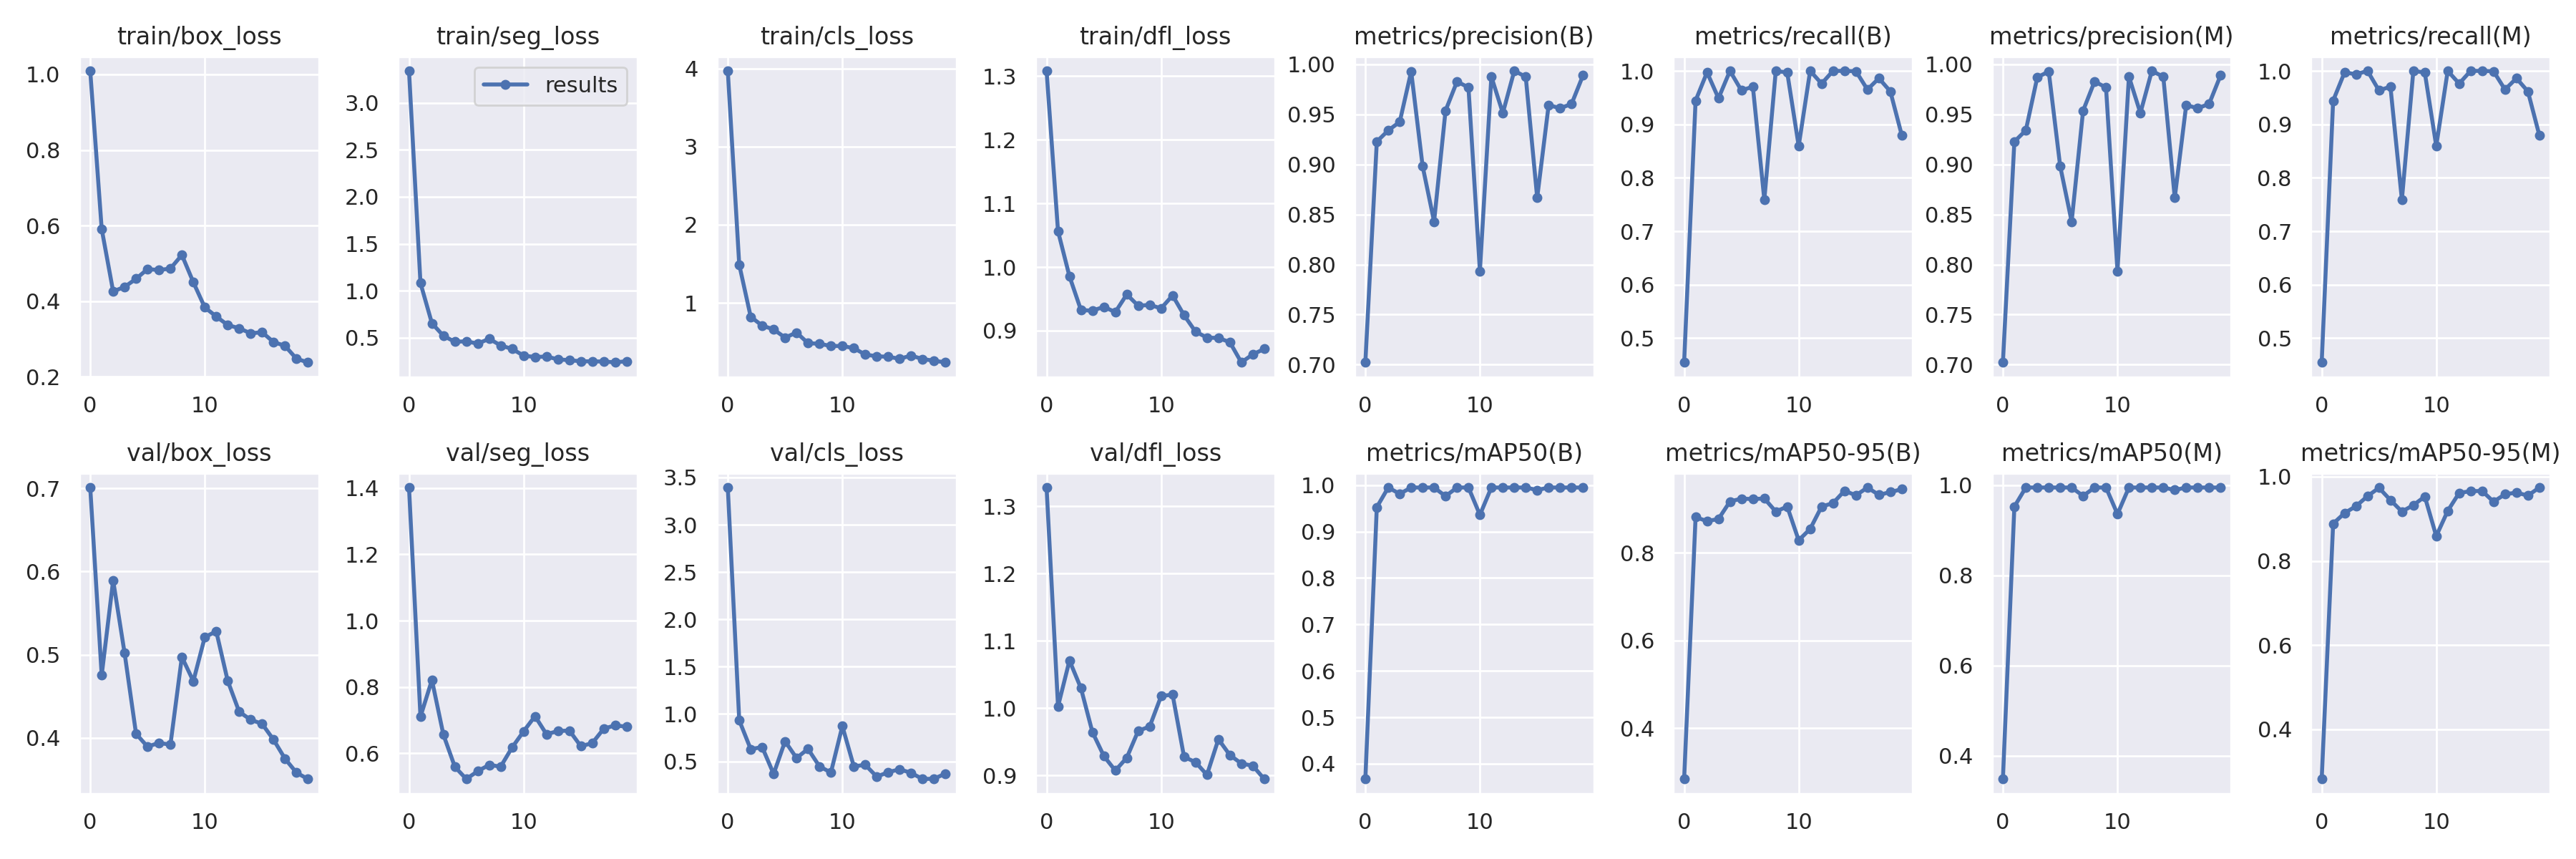

In [8]:
Image(filename=f'/content/runs/segment/train/results.png', width=800)

## Confusion matrix

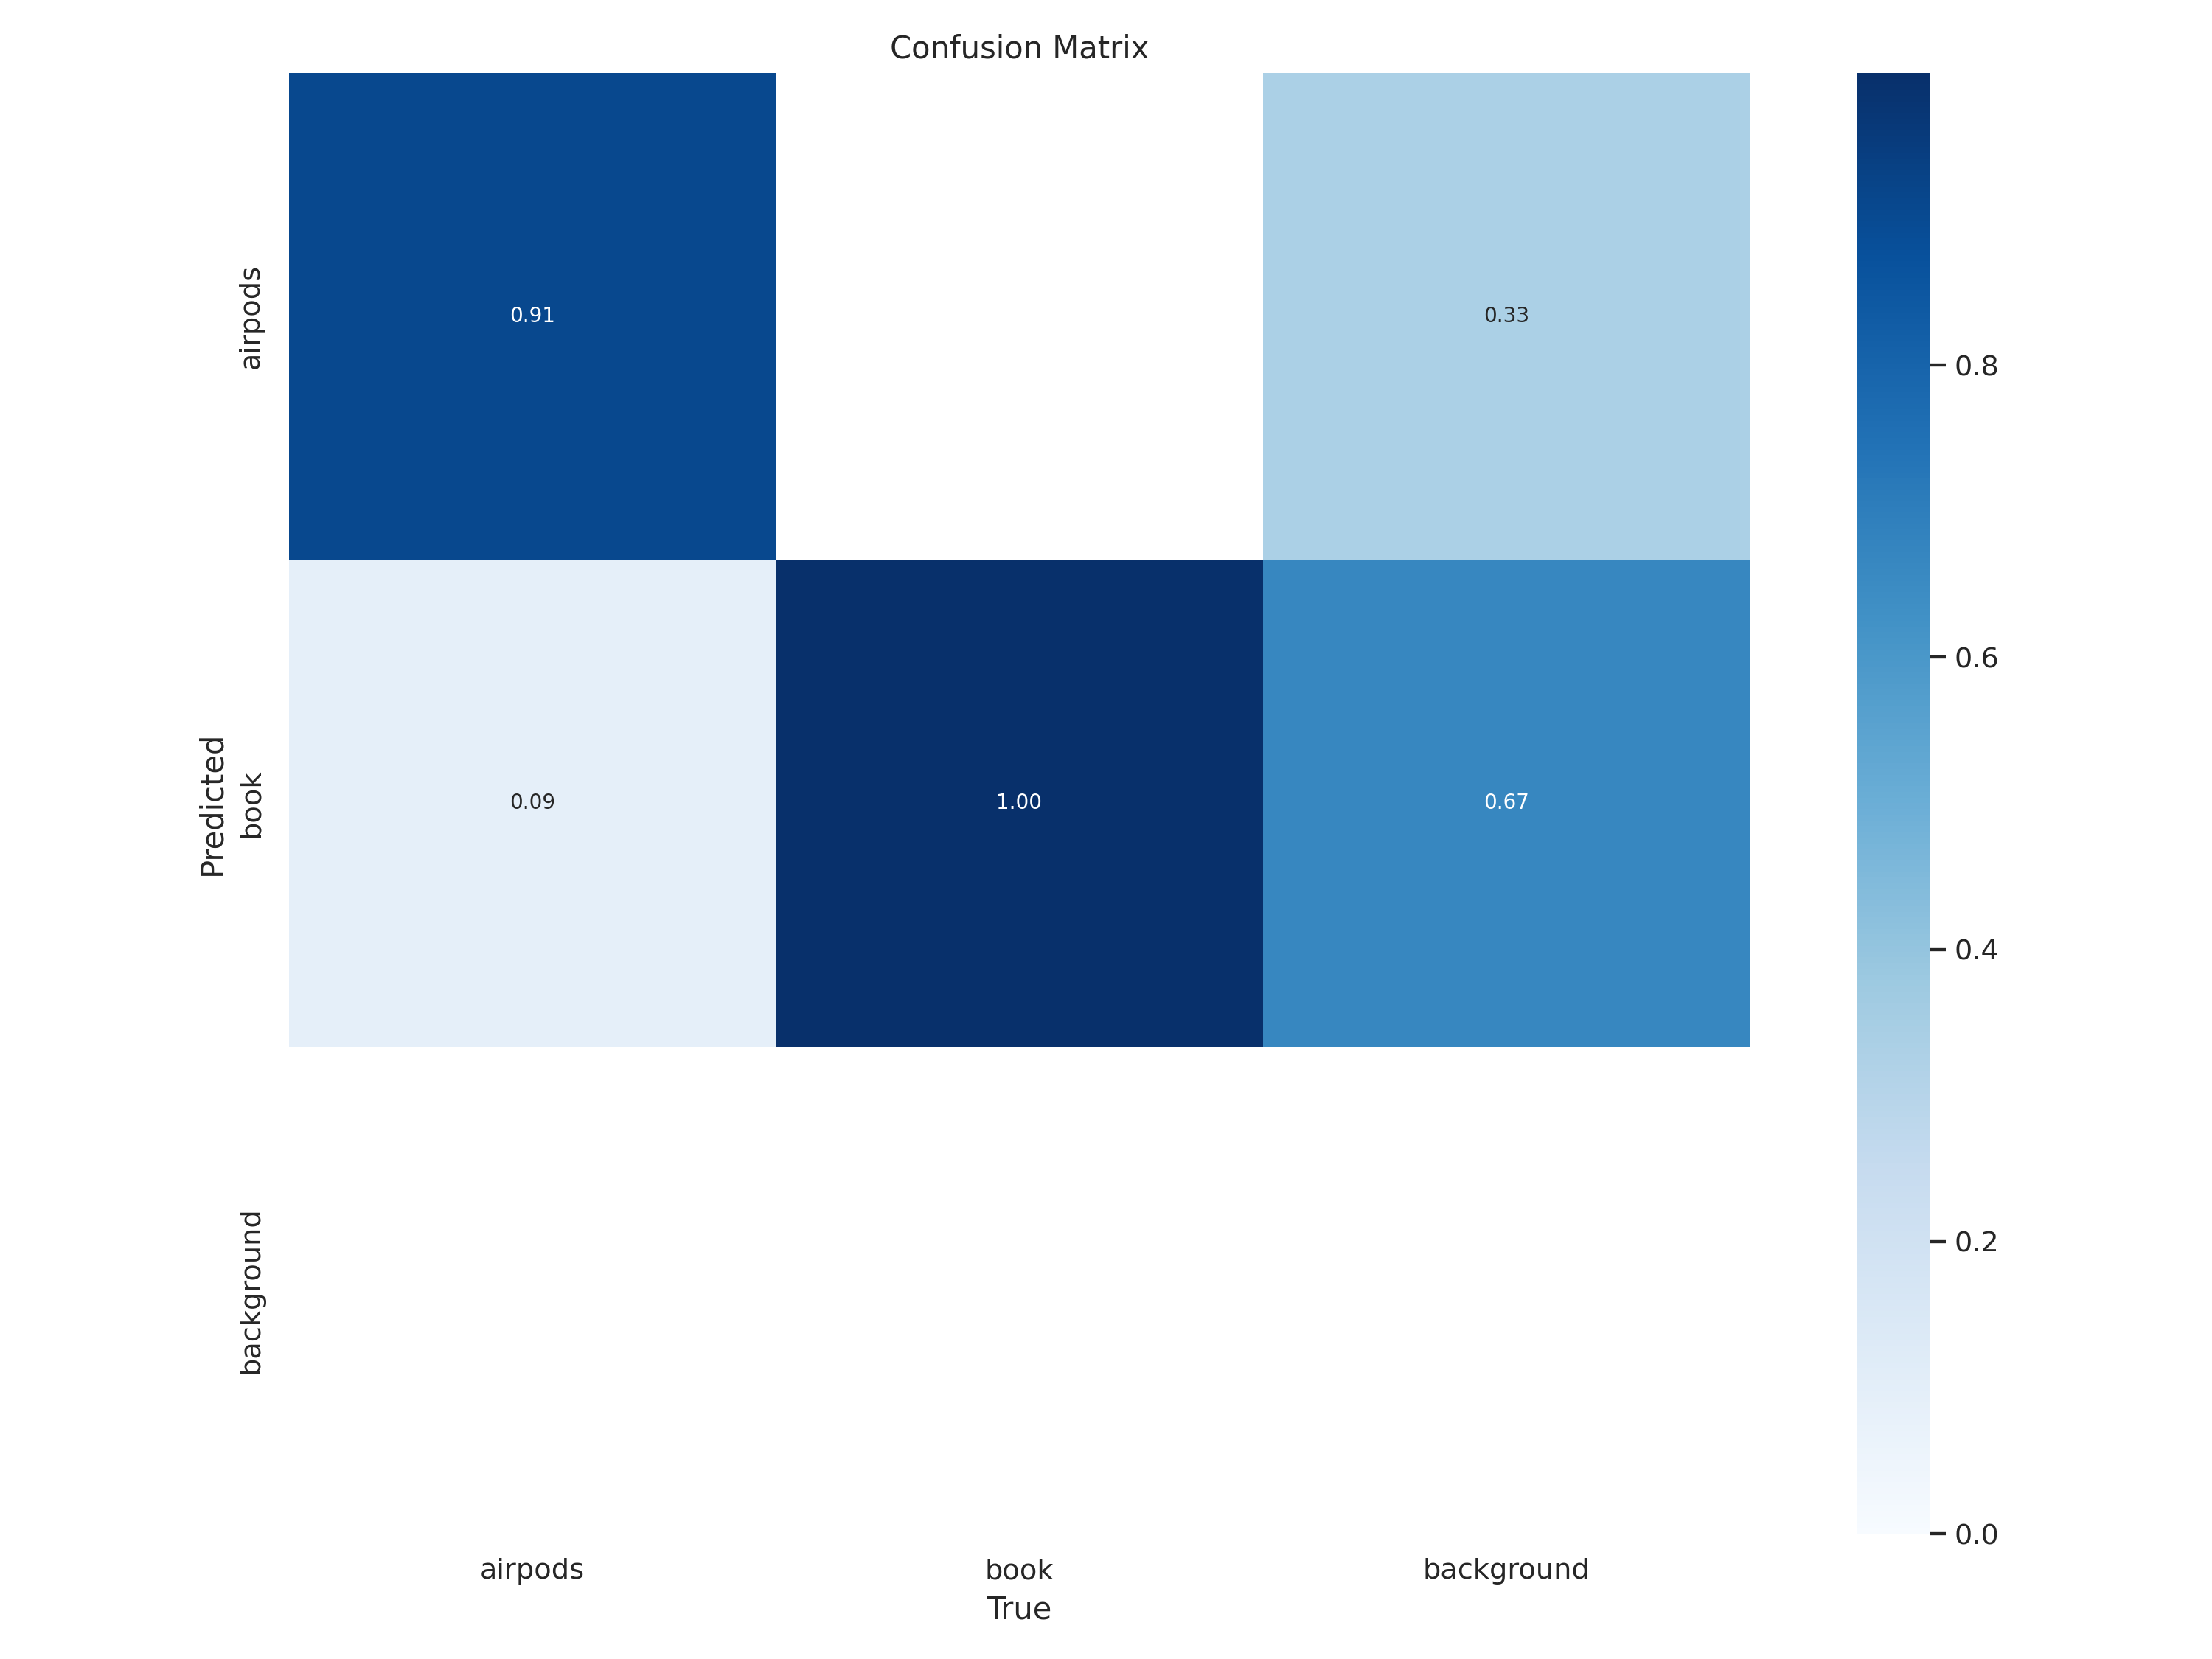

In [9]:
Image(filename=f'/content/runs/segment/train/confusion_matrix.png', width=800)

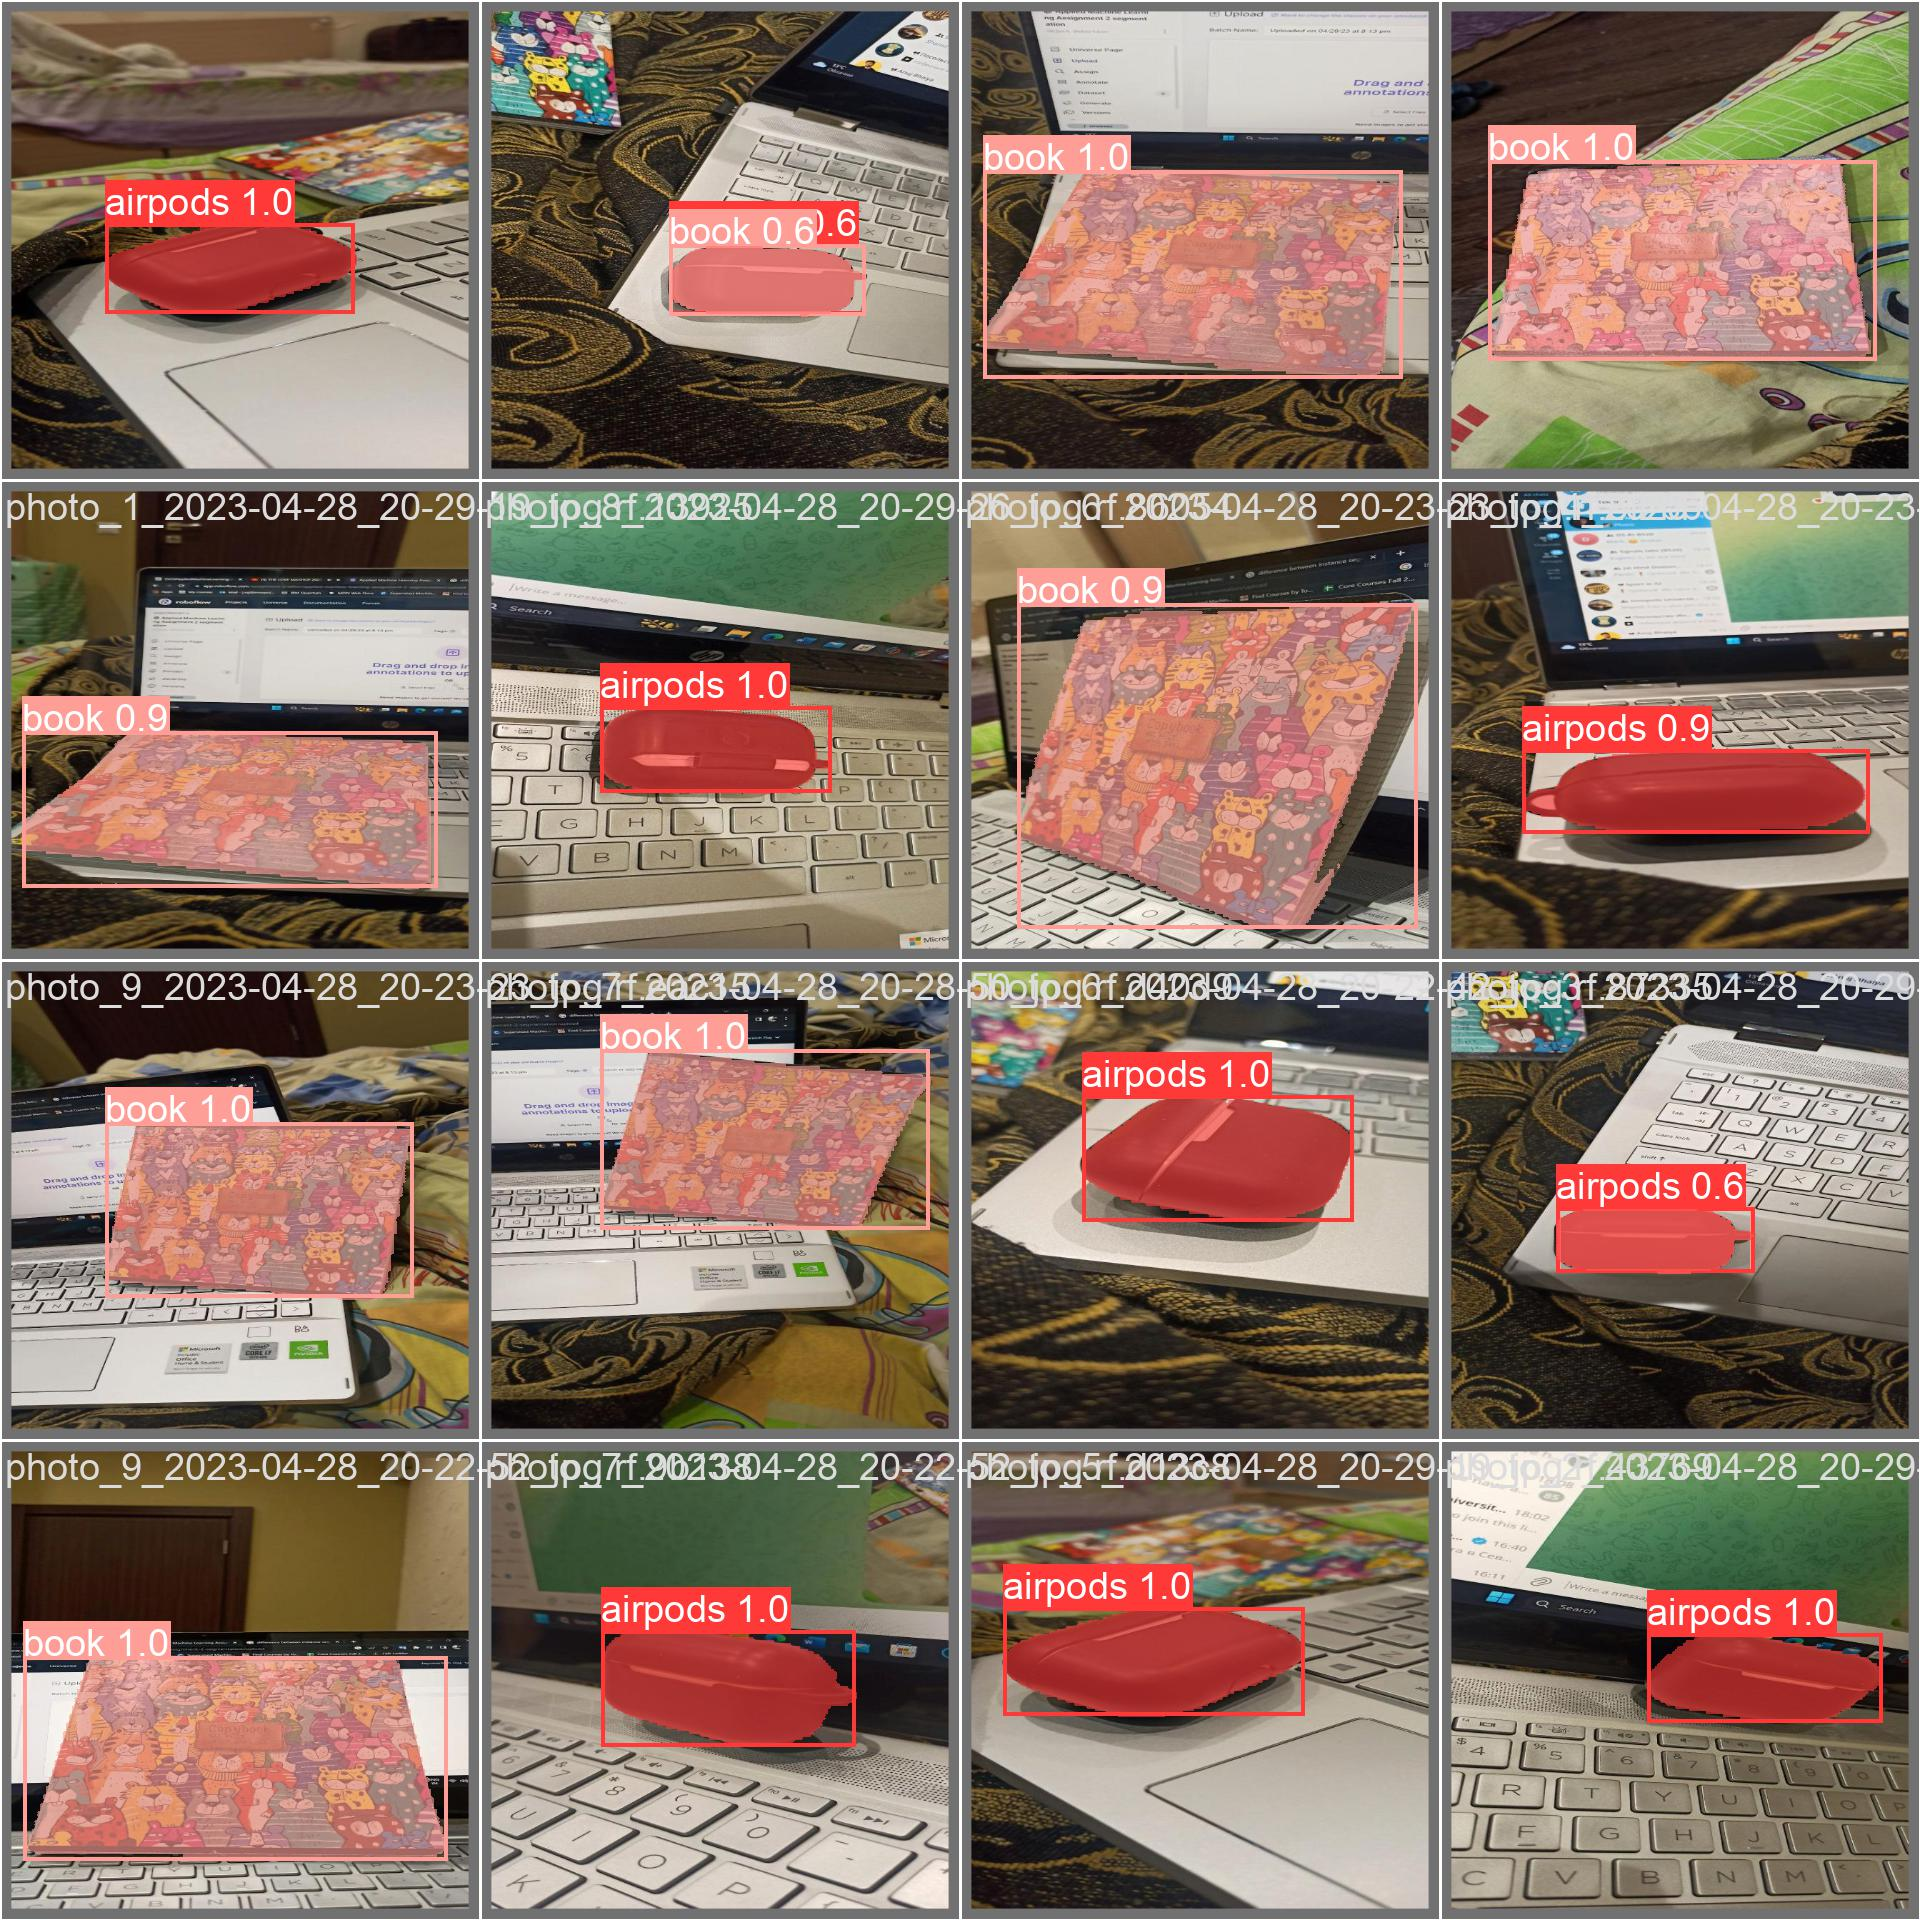

In [11]:
Image(filename=f'/content/runs/segment/train/val_batch0_pred.jpg', width=800)

# Comparison

## Mean Average Precision
- ###  Mask RCNN: 79.77%
- ###  Yolov8: 97.4%

## Speed
- ### Yolov8's significant speed advantage provides numerous benefits, even considering its size.
- ###  Training Yolov8 for 20 epochs takes approximately 3-4 minutes, whereas MASK RCNN requires approximately 55-56 minutes.

## Size
- ### Mask RCNN: 335.82 Mb
- ### Yolov8: 22.79 Mb